# *scikit-image* demo

Tous les modules et sous-modules utilisés dans cette démo sont chargés ici.

In [1]:
# import all modules and submodules used in this demo

import os

import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.exposure
import skimage.measure
import skimage.filters

In [2]:
# %matplotlib inline

L'image analysée dans cette démo est chargée avec la fonction `imread()` du sous-module `skimage.io`. Il s'agit d'une image RGB stockée dans un fichier au format TIFF (extension `.tif`.

In [6]:
fname = os.path.join("./img", "FluorescentCells.tif")
fluocells = skimage.io.imread(fname)
print(type(fluocells))

<class 'numpy.ndarray'>


L'image est stockée dans un objet de type `numpy.ndarray`. Nous pouvons donc utiliser ses attributs (notamment `.ndim`, `.size`, `.shape`, `.min()`, `.max()`, et `.dtype`) pour obtenir quelques informations supplémentaires sur cette image.

In [20]:
print(fluocells.ndim, "dimensions")
print(fluocells.size, "elements")
print("Shape:", fluocells.shape)
print(f"Range: {fluocells.min()}..{fluocells.max()} ({fluocells.dtype})")

3 dimensions
786432 elements
Shape: (512, 512, 3)
Range: 0..255 (uint8)


L'image comporte trois dimensions. Comme vu dans l'introduction, les deux premières dimensions correspondent aux coordonnées (ligne, colonne) des pixels de l'image, alors que la troisième dimension correspond aux canaux rouge, vert, et bleu.

La valeur de chaque pixel dans un canal donné est comprise entre `0` (intensité minimale) et `255` (intensité maximale). Cette gamme de valeurs est en effet utilisée par le type de données `uint8`.

Affichons l'image à l'aide de la fonction `imshow()` du module `matplotlib.pyplot` (alias `plt`).

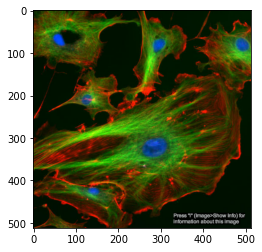

In [27]:
plt.imshow(fluocells);

D'après [ce document](https://imagej.nih.gov/ij/images/FluorescentCells.txt), il s'agit d'une image de cellules endothéliales bovines obtenue par microscopie à fluorescence. Les filaments d'actine sont marqués en rouge, les microtubules en vert, et les noyaux en bleu.

Commençons par extraire chaque canal de cette image en utilisant des tranches sur `fluocells`, l'*array* `numpy` dans lequel elle est stockée.

In [33]:
# extract red, green, and blue channels
fluocells_r = fluocells[:, :, 0] # red
fluocells_g = fluocells[:, :, 1] # green
fluocells_b = fluocells[:, :, 2] # blue

print("fluocells_r shape:", fluocells_r.shape)
print("fluocells_g shape:", fluocells_g.shape)
print("fluocells_b shape:", fluocells_b.shape)

fluocells_r shape: (512, 512)
fluocells_g shape: (512, 512)
fluocells_b shape: (512, 512)


On voit que les *arrays* `numpy` résultants de ces tranchages n'ont conservé que deux dimensions correspondant aux coordonnées (ligne, colonne) des pixels de l'image, la troisième dimension, qui précisait les canaux dans l'*array* `numpy` d'origine, a elle disparu.



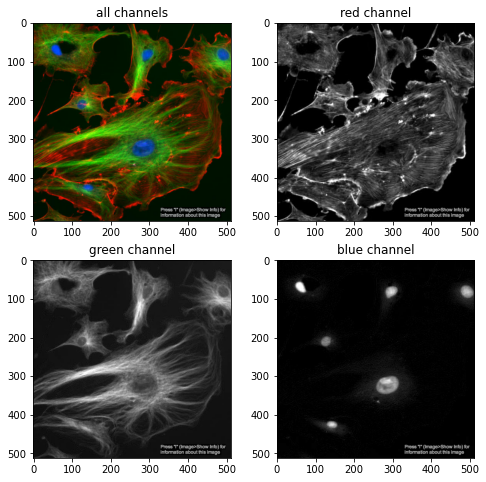

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

axes[0, 0].imshow(fluocells)
axes[0, 0].set_title("all channels")

axes[0, 1].imshow(fluocells_r, cmap="gray")
axes[0, 1].set_title("red channel")

axes[1, 0].imshow(fluocells_g, cmap="gray")
axes[1, 0].set_title("green channel")

axes[1, 1].imshow(fluocells_b, cmap="gray")
axes[1, 1].set_title("blue channel");

Commençons par découper l'image afin de retirer le texte (situé en bas), qui risquerait autrement de nous gêner dans nos analyses.

In [ ]:
# remove the text; to do directly on the data file

fluocells_b = fluocells_b[:475, :]
plt.imshow(fluocells_b, cmap="gray");

## Filtering and segmentation

In [ ]:
hist, bins = skimage.exposure.histogram(fluocells_b)
plt.plot(bins, hist)
plt.ylim(0, 100)
# plt.title("fluocells_b pixel values")
plt.xlabel(f"pixel value ({fluocells_b.dtype})")
plt.ylabel("count");

In [ ]:
threshold = 80
nuclei = (fluocells_b > threshold).astype(int)

plt.imshow(nuclei, cmap="gray");

Background pixels are

In [ ]:
fluocells_b_filtered = skimage.filters.gaussian(fluocells_b,
                                                sigma=2,
                                                preserve_range=True)

plt.imshow(fluocells_b_filtered, cmap="gray");

In [ ]:
threshold = 80
true_nuclei = (fluocells_b_filtered > threshold).astype(int)

plt.imshow(true_nuclei, cmap="gray");

Background pixels have been filtered out.

In [ ]:
nuclei_lab, nuclei_num = skimage.measure.label(true_nuclei, return_num=True)
print("Number of nuclei:", nuclei_num)

plt.imshow(nuclei_lab, cmap="nipy_spectral");

In [ ]:
nuclei_obj = []
for i in range(nuclei_num):
    nuc = (nuclei_lab == i + 1)
    nuclei_obj.append(nuc)

fig, ax = plt.subplots(nrows=nuclei_num, ncols=1, figsize=(30, 30))

for i, nuc in enumerate(nuclei_obj):
    ax[i].imshow(nuc, cmap="gray")
    ax[i].set_title("nuc_" + str(i + 1))

## Measurements

In [ ]:
# nuclei areas

nuc_areas = np.zeros(nuclei_num, int)

for i in range(nuclei_num):
    nuc_areas[i] = np.sum(nuclei_obj[i])
    print(f"nuc_{i + 1} area: {nuc_areas[i]} pixels")
    
plt.hist(nuc_areas, bins=10)
plt.xlabel("area (pixel)")
plt.ylabel("count");

In [ ]:
# nuclei mean intensities

nuc_ints = np.zeros(nuclei_num, int)

for i in range(nuclei_num):
    nuc_ints[i] = np.sum(nuclei_obj[i] * fluocells_b) / nuc_areas[i]
    print(f"nuc_{i + 1} mean intensity: {nuc_ints[i]} per pixel")
nuc_ints

plt.hist(nuc_ints, bins=10)
plt.xlabel("mean intensity (per pixel)")
plt.ylabel("count");

### Measuring nuclei areas and intensities using *scikit-image* functions

In [ ]:
nuclei_props = skimage.measure.regionprops(nuclei_lab,
                                           intensity_image=fluocells_b)

nuclei_props_areas = np.zeros(nuclei_num)
nuclei_props_ints = np.zeros(nuclei_num)

for i in range(len(nuclei_props)):
    nuclei_props_areas[i] = nuclei_props[i].area
    nuclei_props_ints[i] = nuclei_props[i].mean_intensity

plt.plot(nuclei_props_areas, nuclei_props_ints, "s")
plt.xlabel("area (pixel)")
plt.ylabel("mean intensity (per pixel)");